In [16]:
import numpy as np
from torch.fft import fft2, ifft2, fftshift, ifftshift
import torchvision.transforms as trans
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
from focal_frequency_loss import FocalFrequencyLoss as FFL
from torch import Tensor
from torchvision.utils import _log_api_usage_once

In [17]:
image_path = '../data/20-imagenet_seperate_images/train/img_9.png'
# def plot_fft(image_path):
_image = Image.open(image_path)
to_tensor = trans.ToTensor()
_image_tensor = to_tensor(_image)
if _image_tensor.shape[1] >= 244 or _image_tensor.shape[2] >= 244:
    _image_tensor = trans.transforms.Resize((224, 224))(_image_tensor)
_image_fft = fft.fft2(_image_tensor,dim=(-2,-1))
_image_fft = fft.fftshift(_image_fft,dim=(-2,-1))
print(_image_fft.shape)
to_PIL = trans.ToPILImage()
_image = to_PIL(_image_tensor)
_image_fft = _image_fft.sum(axis=0)
# _image_fft = np.log(np.abs(_image_fft) + 1)
_image_fft = np.abs(_image_fft)
# return _image,_image_fft,_image_tensor

torch.Size([3, 224, 224])


In [18]:
_image_tensor.shape,_image_fft.shape

(torch.Size([3, 224, 224]), torch.Size([224, 224]))

In [19]:
class low_freq_substitution:
    # now use a fix image
    def __init__(self, input_height, input_width, low_freq_image, alpha, beta=1) -> None:
        _log_api_usage_once(self)
        # the shape of image is [C.H.W]
        # assert if not match the shape
        assert low_freq_image.shape[0] == 3 and low_freq_image.shape[
            1] == input_height and low_freq_image.shape[2] == input_width, 'the shape of low_freq_image should be [3, input_height, input_width]'
        self.alpha = alpha
        self.beta = beta
        self.input_height = input_height
        self.input_width = input_width
        # prepare low frequency mask and low frequency fft
        # shape of low_freq_image_fft is [3, input_height, input_width]
        low_freq_image_fft = fft2(low_freq_image, dim=(-2, -1))
        low_freq_image_fft = fftshift(low_freq_image_fft, dim=(-2, -1))
        low_freq_image_fft = torch.abs(low_freq_image_fft)
        self.low_freq_image_fft = low_freq_image_fft
        center = ((input_height-1)/2, (input_width-1)/2)
        max_radius = min(
            center[0], center[1], input_height-center[0], input_width-center[1])
        radius = max_radius*alpha
        self.mask = torch.zeros(input_height, input_width)
        for i in range(input_height):
            for j in range(input_width):
                if (i-center[0])**2 + (j-center[1])**2 <= radius**2:
                    self.mask[i][j] = beta

    # ???? how about the phase of the image

    # replace the low frequency part of the image with the low frequency part of a random image
    def forward(self, tensor: Tensor) -> Tensor:
        # get the amplitude and phase of the input image
        tensor_fft = fft2(tensor, dim=(-2, -1))
        tensor_fft = fftshift(tensor_fft, dim=(-2, -1))
        tensor_amplitude = torch.abs(tensor_fft)
        tensor_phase = torch.angle(tensor_fft)
        # replace low frequency part with self.low_freq_image_fft and mask
        tensor_amplitude = self.mask * self.low_freq_image_fft + \
            (1-self.mask) * tensor_amplitude
        # get the new image tensor
        tensor_fft = torch.polar(tensor_amplitude, tensor_phase)
        tensor_fft = ifftshift(tensor_fft, dim=(-2, -1))
        tensor = ifft2(tensor_fft, dim=(-2, -1))
        tensor = torch.abs(tensor)
        return tensor

    def __call__(self, tensor: Tensor) -> Tensor:
        return self.forward(tensor)

    def __repr__(self) -> str:
        return f"low_freq_substitution(alpha={self.alpha}, beta={self.beta})"


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


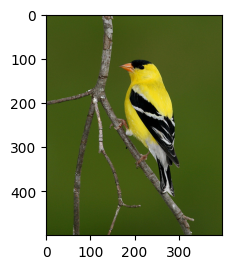

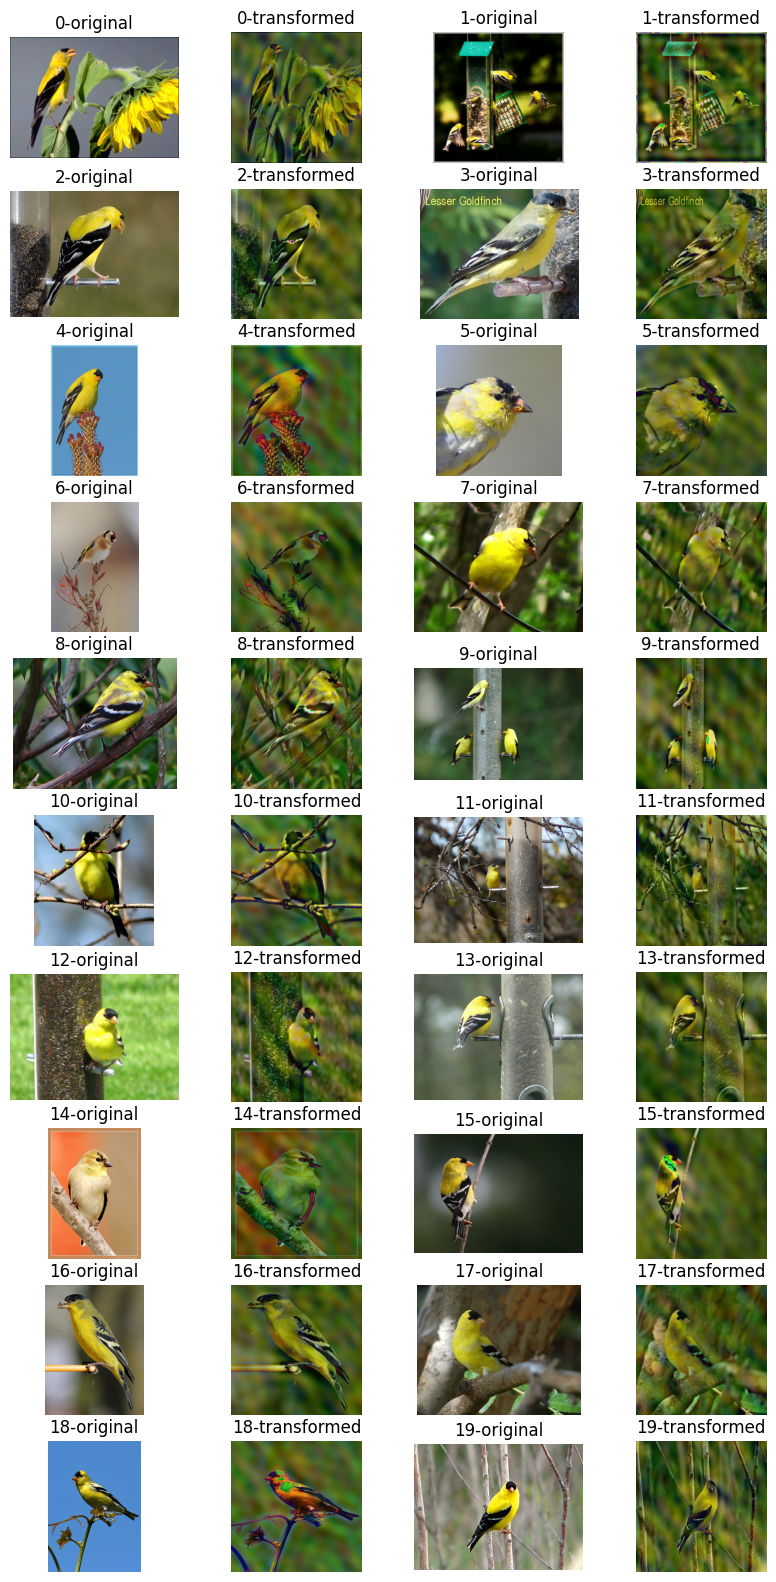

In [23]:
import os
image_path1 = '../data/20-imagenet_seperate_images/train/img_9.png'
image_path2 = '../data/20-imagenet_seperate_images/train/img_10.png'
root = '../data/20-imagenet/train/n01531178'
images = os.listdir(root)
# def plot_fft(image_path):
_image1 = Image.open(image_path1)

fig = plt.figure(figsize=(5,5))
fig.add_subplot(1,2,1)
plt.imshow(_image1)

to_tensor = trans.ToTensor()
resize = trans.Resize((224, 224))
low_freq_image = resize(_image1)
low_freq_image = to_tensor(low_freq_image)
transform = trans.Compose([
    trans.Resize((224, 224)),
    trans.ToTensor(),
    low_freq_substitution(224, 224, low_freq_image, 0.95)
])
# transformed_image1 = transform(_image1)
# transformed_image2 = transform(_image2)
# fig = plt.figure(figsize=(5,5))
# fig.add_subplot(1,2,1)
# plt.imshow(trans.ToPILImage()(transformed_image1))
# fig.add_subplot(1,2,2)
# plt.imshow(trans.ToPILImage()(transformed_image2))

length = 20
columns = 4
fig = plt.figure(figsize=(10,4*length/columns))
transform = trans.Compose([
    trans.Resize((224, 224)),
    trans.ToTensor(),
    low_freq_substitution(224, 224, low_freq_image, 0.09),
    trans.ToPILImage()
])
from tqdm import tqdm
for index in tqdm(range(length)):
    image = Image.open(os.path.join(root, images[index]))
    fig.add_subplot(2*int(length/columns), columns, index*2+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(str(index)+'-original')
    fig.add_subplot(2*int(length/columns), columns, index*2+2)
    plt.imshow(transform(image))
    plt.axis('off')
    plt.title(str(index)+'-transformed')



# # test if can recover image from fft
# image_tensor = to_tensor(_image1)
# image_fft = fft.fft2(image_tensor,dim=(-2,-1))
# image_fft = fft.fftshift(image_fft,dim=(-2,-1))
# image_fft_amplitude = torch.abs(image_fft)
# image_fft_phase = torch.angle(image_fft)
# image_fft = torch.polar(image_fft_amplitude, image_fft_phase)
# image_fft = fft.ifftshift(image_fft,dim=(-2,-1))
# image_tensor = fft.ifft2(image_fft,dim=(-2,-1))
# image_tensor = torch.real(image_tensor)
# image_recoverd = to_PIL(image_tensor)
# fig = plt.figure(figsize=(5,5))
# fig.add_subplot(1,2,1)
# plt.imshow(_image1)
# fig.add_subplot(1,2,2)
# plt.imshow(image_recoverd)